# **Install and import required packages**


In [1]:
import numpy as np
import math
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import confusion_matrix

# **Mount Google drive**

In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


# **Download dataset**

In [3]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip

--2020-12-16 12:39:41--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  4.13MB/s    in 70s     

2020-12-16 12:40:52 (6.41 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [4]:
def read_off(file):
    if file.readline().strip() != 'OFF':
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

def visualize(data):
    m = {
        'type':'buttons','showactive': False,
        'y':1,'x':0.8, 'xanchor':'left','yanchor':'bottom',
        'pad':dict(t=45, r=10),
    }
    fig = go.Figure(data=data, layout=go.Layout(updatemenus=[m]))
    return fig


In [5]:
def point_sampler(mesh, output_size=1024):
    verts, faces = mesh
    lookup = lambda v,f,i: (v[f[i][0]],v[f[i][1]],v[f[i][2]])
    tri_area = lambda a,b,c: abs(0.5 * (((b[0]-a[0])*(c[1]-a[1]))-((c[0]-a[0])*(b[1]-a[1]))))
    face_area = lambda i: tri_area(verts[faces[i][0]],verts[faces[i][1]],verts[faces[i][2]])

    verts, areas = np.array(verts), np.array([face_area(i) for i in range(len(faces))])
    samp_f = random.choices(faces, weights=areas, cum_weights=None, k=output_size)
    samp_p = np.zeros((output_size, 3))

    for i in range(len(samp_f)):
        v1,v2,v3 = lookup(verts, samp_f, i)
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * v1[i] + (t-s)*v2[i] + (1-t)*v3[i]
        samp_p[i] = (f(0), f(1), f(2))
    return samp_p

def normalize(pointcloud):
    norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
    norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
    return  norm_pointcloud

def rand_rotate(pointcloud):
    t = random.random() * 2. * math.pi
    c, s = math.cos(t), math.sin(t)
    rot_matrix = np.array([[c, -s, 0],[s, c, 0],[0, 0, 1]])
    rot_pointcloud = rot_matrix.dot(pointcloud.T).T
    return  rot_pointcloud

def rand_noise(pointcloud):
    return  pointcloud + np.random.normal(0, 0.02, (pointcloud.shape))

def ToTensor(pointcloud):
    return torch.from_numpy(pointcloud)


In [6]:
train_transforms = transforms.Compose([
                    point_sampler,
                    normalize,
                    rand_rotate,
                    rand_noise
                    ])

In [7]:
class PC:
    def __init__(self, verts, faces):
        self.verts = verts
        self.faces = faces
        self.pointcloud = point_sampler((verts, faces))
        # self.points_sample()

    def show_mesh(self):
        i,j,k = np.array(self.faces).T
        x,y,z = np.array(self.verts).T
        data = [go.Mesh3d(x=x, y=y, z=z, color='lightgreen', opacity=0.50, i=i,j=j,k=k)]
        fig = visualize(data)
        fig.show()

    def show_scatter(self):
        x,y,z = np.array(self.verts).T
        data = [go.Scatter3d(x=x, y=y, z=z, mode='markers')]
        fig = visualize(data)
        fig.show()

    def show_point_cloud(self):
        p = self.pointcloud
        data = [go.Scatter3d(x=p[:,0], y=p[:,1], z=p[:,2], mode='markers')]
        fig = visualize(data).update_traces(
                                        marker=dict(size=2, 
                                        line=dict(width=2, color='DarkSlateGrey')), 
                                        selector=dict(mode='markers'))
        fig.show()

    def transform(self):
        self.pointcloud = train_transforms((self.verts, self.faces))

In [8]:
root_dir, cate = "./ModelNet10", "bathtub"
with open(os.path.join(root_dir, "{}/train/{}_0001.off".format(cate, cate)), 'r') as f:
  verts, faces = read_off(f)
  p = PC(verts, faces)

In [9]:
p.show_mesh()

In [10]:
p.show_scatter()

In [11]:
# p.transform()
p.show_point_cloud()

In [9]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, folder="train"):
        self.root_dir = root_dir
        # folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, dir))]
        # self.classes = {folder: i for i, folder in enumerate(folders)}
        self.classes = self.get_categories()
        self.files = []
        for category in self.classes.keys():
            new_dir = os.path.join(root_dir, category, folder)
            for fn in os.listdir(new_dir):
                if fn.endswith('.off'):
                    self.files.append(dict(fn=os.path.join(new_dir, fn), category=category))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]['fn']
        category = self.files[idx]['category']
        with open(fn, 'r') as f:
            verts, faces = read_off(f)
            p = PC(verts, faces)
            p.transform()
        return {'pointcloud': ToTensor(p.pointcloud), 
                'category': self.classes[category]}
            # return (ToTensor(p.pointcloud), self.classes[category])

    def get_categories(self):
        list_dir = sorted(os.listdir(self.root_dir))
        list_dir = [dir for dir in list_dir if os.path.isdir(os.path.join(self.root_dir, dir))]
        classes = {folder: i for i, folder in enumerate(list_dir)}
        return classes

In [10]:
train_ds = PointCloudData('./ModelNet10', folder="train")
valid_ds = PointCloudData('./ModelNet10', folder="test")

In [11]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [12]:
print("# of training samples: ", len(train_ds))
print("# of validation samples: ", len(valid_ds))
print("# of classes: ", len(train_ds.classes))
print("pointcloud dimension: ", train_ds[0]['pointcloud'].shape)

# of training samples:  3991
# of validation samples:  908
# of classes:  10
pointcloud dimension:  torch.Size([1024, 3])


In [13]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [13]:
# import torch
# import torch.nn as nn
# import numpy as np
# import torch.nn.functional as F

# class Tnet(nn.Module):
#    def __init__(self, k=3):
#       super().__init__()
#       self.k=k
#       self.conv1 = nn.Conv1d(k,64,1)
#       self.conv2 = nn.Conv1d(64,128,1)
#       self.conv3 = nn.Conv1d(128,1024,1)
#       self.fc1 = nn.Linear(1024,512)
#       self.fc2 = nn.Linear(512,256)
#       self.fc3 = nn.Linear(256,k*k)

#       self.bn1 = nn.BatchNorm1d(64)
#       self.bn2 = nn.BatchNorm1d(128)
#       self.bn3 = nn.BatchNorm1d(1024)
#       self.bn4 = nn.BatchNorm1d(512)
#       self.bn5 = nn.BatchNorm1d(256)
       

#    def forward(self, input):
#       # input.shape == (bs,n,3)
#       bs = input.size(0)
#       xb = F.relu(self.bn1(self.conv1(input)))
#       xb = F.relu(self.bn2(self.conv2(xb)))
#       xb = F.relu(self.bn3(self.conv3(xb)))
#       pool = nn.MaxPool1d(xb.size(-1))(xb)
#       flat = nn.Flatten(1)(pool)
#       xb = F.relu(self.bn4(self.fc1(flat)))
#       xb = F.relu(self.bn5(self.fc2(xb)))
      
#       #initialize as identity
#       init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
#       if xb.is_cuda:
#         init=init.cuda()
#       matrix = self.fc3(xb).view(-1,self.k,self.k) + init
#       return matrix


# class Transform(nn.Module):
#    def __init__(self):
#         super().__init__()
#         self.input_transform = Tnet(k=3)
#         self.feature_transform = Tnet(k=64)
#         self.conv1 = nn.Conv1d(3,64,1)

#         self.conv2 = nn.Conv1d(64,128,1)
#         self.conv3 = nn.Conv1d(128,1024,1)
       

#         self.bn1 = nn.BatchNorm1d(64)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.bn3 = nn.BatchNorm1d(1024)
       
#    def forward(self, input):
#         matrix3x3 = self.input_transform(input)
#         # batch matrix multiplication
#         xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

#         xb = F.relu(self.bn1(self.conv1(xb)))

#         matrix64x64 = self.feature_transform(xb)
#         xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

#         xb = F.relu(self.bn2(self.conv2(xb)))
#         xb = self.bn3(self.conv3(xb))
#         xb = nn.MaxPool1d(xb.size(-1))(xb)
#         output = nn.Flatten(1)(xb)
#         return output, matrix3x3, matrix64x64

# class PointNet(nn.Module):
#     def __init__(self, classes = 10):
#         super().__init__()
#         self.transform = Transform()
#         self.fc1 = nn.Linear(1024, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, classes)
        

#         self.bn1 = nn.BatchNorm1d(512)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.dropout = nn.Dropout(p=0.3)
#         self.logsoftmax = nn.LogSoftmax(dim=1)

#     def forward(self, input):
#         xb, matrix3x3, matrix64x64 = self.transform(input)
#         xb = F.relu(self.bn1(self.fc1(xb)))
#         xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
#         output = self.fc3(xb)
#         return self.logsoftmax(output), matrix3x3, matrix64x64



In [14]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(k,64,1), nn.BatchNorm1d(64))
        self.conv2 = nn.Sequential(nn.Conv1d(64,128,1), nn.BatchNorm1d(128))
        self.conv3 = nn.Sequential(nn.Conv1d(128,1024,1), nn.BatchNorm1d(1024))
        self.fc1 = nn.Sequential(nn.Linear(1024,512), nn.BatchNorm1d(512))
        self.fc2 = nn.Sequential(nn.Linear(512,256), nn.BatchNorm1d(256))
        self.fc3 = nn.Linear(256, k*k)
        self.k = k

    def forward(self, input):
        self.conv1_out = F.relu(self.conv1(input))
        self.conv2_out = F.relu(self.conv2(self.conv1_out))
        self.conv3_out = F.relu(self.conv3(self.conv2_out))

        maxpool = nn.Flatten(1)(nn.MaxPool1d(1024)(self.conv3_out)) # torch.Size([32, 1024])
        self.fc1_out = F.relu(self.fc1(maxpool))
        self.fc2_out = F.relu(self.fc2(self.fc1_out))
        
        #initialize as identity
        batch_size = input.size(0) # torch.Size([32, 3, 1024])
        identity = torch.eye(self.k, requires_grad=True).repeat(batch_size,1,1).cuda() # torch.Size([32, k, k])
        t = self.fc3(self.fc2_out).view(-1, self.k, self.k) + identity
        return t


class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Sequential(nn.Conv1d(3,64,1), nn.BatchNorm1d(64))
        self.conv2 = nn.Sequential(nn.Conv1d(64,128,1), nn.BatchNorm1d(128))
        self.conv3 = nn.Sequential(nn.Conv1d(128,1024,1), nn.BatchNorm1d(1024))

        self.fc1 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.3), nn.BatchNorm1d(256))
        self.fc3 = nn.Sequential(nn.Linear(256, classes), nn.LogSoftmax(dim=1))

    def forward(self, input):
        t3 = self.input_transform(input)
        trans_input = torch.bmm(torch.transpose(input,1,2), t3).transpose(1,2)
        self.conv1_out = F.relu(self.conv1(trans_input))

        t64 = self.feature_transform(self.conv1_out)
        trans_feature = torch.bmm(torch.transpose(self.conv1_out,1,2), t64).transpose(1,2)
        self.conv2_out = F.relu(self.conv2(trans_feature))
        self.conv3_out = self.conv3(self.conv2_out)
        self.trans_output = nn.Flatten(1)(nn.MaxPool1d(1024)(self.conv3_out))

        self.fc1_out = F.relu(self.fc1(self.trans_output))
        self.fc2_out = F.relu(self.fc2(self.fc1_out))
        self.output = self.fc3(self.fc2_out)
        return self.output, t3, t64

In [20]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

def train(train_loader, val_loader=None,  epochs=40):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pointnet = PointNet()
    pointnet.to(device)
    optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
    if os.path.exists("./drive/My Drive/point_net_models/logs.txt"):
        os.remove("./drive/My Drive/point_net_models/logs.txt")

    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs): 
        pointnet.train()
        running_loss, total_loss = 0.0, 0.0
        correct = total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        hist['loss'].append(total_loss / len(train_loader))
        hist['acc'].append(100. * correct / total)
        print('train accuracy: {}'.format(100.0 * correct / total))
        print('train loss: {}'.format(total_loss / len(train_loader)))

        file = open("./drive/My Drive/point_net_models/logs.txt","a") 
        file.write('epoch:{}\t train_loss:{}\t train_acc:{}\n'.format(epoch+1, total_loss / len(train_loader), 100.0 * correct / total)) 
        file.close()

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                all_loss = 0
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
                    loss = pointnetloss(outputs, labels, m3x3, m64x64)
                    all_loss += loss

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('valid accuracy: {}'.format(val_acc))
            print('valid loss: {}'.format(all_loss/len(val_loader)))

            hist['val_loss'].append(all_loss/len(val_loader))
            hist['val_acc'].append(val_acc)

            file = open("./drive/My Drive/point_net_models/logs.txt","a") 
            file.write('epoch:{}\t val_loss:{}\t val_acc:{}\n'.format(epoch+1, all_loss/len(val_loader), val_acc)) 
            file.close()

        torch.save(pointnet.state_dict(), "./drive/My Drive/point_net_models/save_"+str(epoch)+".pth")

    print(hist)

In [21]:
train(train_loader, valid_loader)

[Epoch: 1, Batch:   10 /  125], loss: 2.092
[Epoch: 1, Batch:   20 /  125], loss: 1.618
[Epoch: 1, Batch:   30 /  125], loss: 1.429
[Epoch: 1, Batch:   40 /  125], loss: 1.271
[Epoch: 1, Batch:   50 /  125], loss: 1.200
[Epoch: 1, Batch:   60 /  125], loss: 1.236
[Epoch: 1, Batch:   70 /  125], loss: 1.052
[Epoch: 1, Batch:   80 /  125], loss: 1.125
[Epoch: 1, Batch:   90 /  125], loss: 1.082
[Epoch: 1, Batch:  100 /  125], loss: 0.937
[Epoch: 1, Batch:  110 /  125], loss: 0.934
[Epoch: 1, Batch:  120 /  125], loss: 0.961
train accuracy: 57.754948634427464
train loss: 1.2292068030834198
valid accuracy: 50.330396475770925
valid loss: 1.5504751205444336
[Epoch: 2, Batch:   10 /  125], loss: 0.913
[Epoch: 2, Batch:   20 /  125], loss: 0.869
[Epoch: 2, Batch:   30 /  125], loss: 0.789
[Epoch: 2, Batch:   40 /  125], loss: 0.882
[Epoch: 2, Batch:   50 /  125], loss: 0.770
[Epoch: 2, Batch:   60 /  125], loss: 0.785
[Epoch: 2, Batch:   70 /  125], loss: 0.894
[Epoch: 2, Batch:   80 /  125], 

In [26]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load("./drive/My Drive/point_net_models/save_39.pth"))
pointnet.eval();

In [27]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [28]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[43,  3,  0,  0,  0,  0,  0,  2,  2,  0],
       [ 0, 92,  0,  0,  0,  0,  0,  4,  4,  0],
       [ 0,  0, 95,  0,  0,  1,  1,  1,  0,  2],
       [ 0,  0,  0, 70,  0,  2,  4,  3,  5,  2],
       [ 0,  0,  0,  0, 57,  9, 14,  0,  2,  4],
       [ 0,  0,  0,  0,  0, 98,  0,  0,  0,  2],
       [ 0,  0,  1,  0, 10,  9, 61,  0,  4,  1],
       [ 0,  0,  1,  1,  0,  0,  0, 97,  0,  1],
       [ 0,  0,  0, 39,  0,  0,  0,  0, 61,  0],
       [ 0,  1,  3,  0,  0,  0,  0,  0,  0, 96]])

Normalized confusion matrix


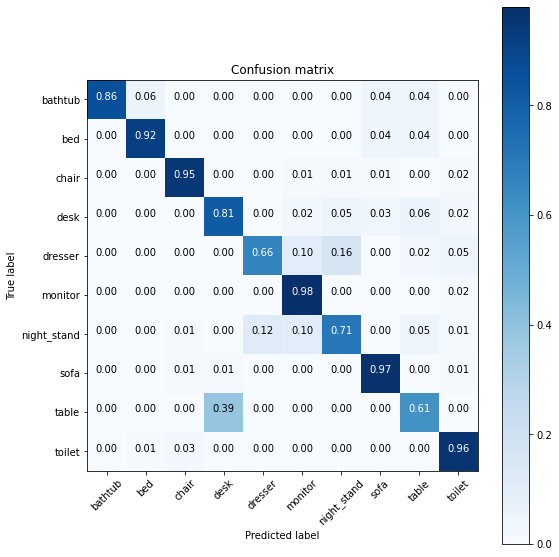

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(train_ds.classes.keys()), normalize=True)

Confusion matrix, without normalization


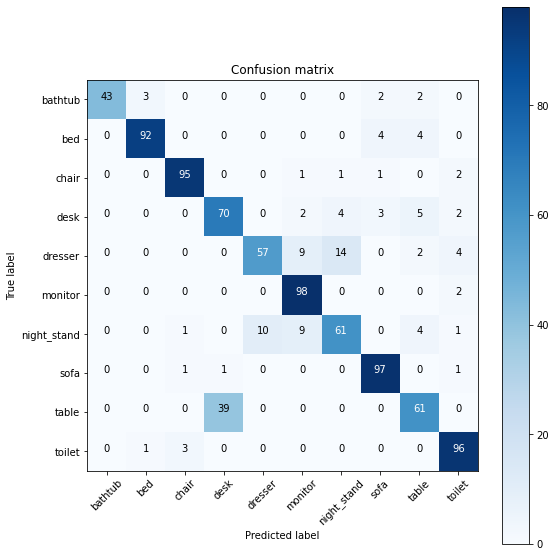

In [32]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(train_ds.classes.keys()), normalize=False)